### Load necessary libraries

In [1]:
from petclassifier import processdata, models, output, figures
import uproot
import uproot_methods
import numpy as np
import matplotlib.pyplot as plt
seed = 11
np.random.seed(seed)

### Set up tenforlow (multiple CPU)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Activation, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, TimeDistributed
from tensorflow.keras import utils
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(device_count={'GPU': 0, 'CPU': 6}, log_device_placement=False ))

### Parameters to specify

In [3]:
FILE_NAME = 'standard_geometry' # file name to load (standard_geomtery)
NEIGHBOURS = 8 # add how many events should be processed around classified event
FOLDER_NAME = 'standard_geometry' # name of the folder (in saved_models) where output will be stored
PATH = 'saved_models/'+FOLDER_NAME
output.create_output_folder(PATH)

Folder saved_models/standard_geometry exists ! Moved to saved_models/backup
Successfully created the directory saved_models/standard_geometry 


Used analysis scheme:
- event to classity is surrounded by X neighbourgs on both sides
- this structure is passed to LSTM layer

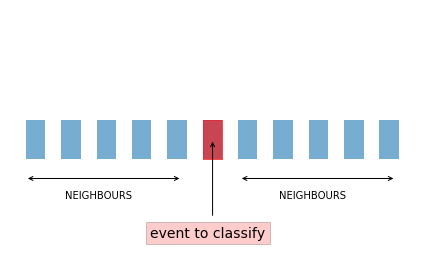

In [4]:
figures.event_scheme()

### Load data

In [5]:
fileIn = uproot.open('data/'+FILE_NAME+'.root')
tree = fileIn["T"]

### Prepare data

In [6]:
NUM_CATEGORIES = 5

In [7]:
x_all, y_all = processdata.prepare_mc_sliding_window(
    tree, NEIGHBOURS, NUM_CATEGORIES)

--- load from file     :  0.14174842834472656 seconds ---
--- data manipulations :  4.232766389846802 seconds ---


### Split into train and test sets

In [8]:
train_size = int(len(x_all) * 0.67)
test_size = len(x_all) - train_size

x_train, x_test = x_all[0:train_size,:], x_all[train_size:len(x_all),:]
y_train, y_test = y_all[0:train_size,:], y_all[train_size:len(y_all),:]

### Prepare model

In [9]:
model = models.LSTMv1(x_train.shape[1:], NUM_CATEGORIES)

In [10]:
EPOCHS = 500
BATCH_SIZE = 256

In [11]:
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [12]:
MODEL_NAME = PATH+'/best_model.h5'
modelCheckpoint = keras.callbacks.ModelCheckpoint(MODEL_NAME,
                                                  monitor='val_accuracy', mode='max',
                                                  verbose=1, save_best_only=True)

### Train

In [ ]:
H = model.fit(x_train,
              y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              callbacks=[modelCheckpoint,earlyStopping],
              validation_data=(x_test, y_test))

Train on 161553 samples, validate on 79572 samples
Epoch 1/500
161536/161553 [============================>.] - ETA: 0s - loss: 1.2090 - accuracy: 0.4853
Epoch 00001: val_accuracy improved from -inf to 0.54935, saving model to saved_models/standard_geometry/best_model.h5
161553/161553 [==============================] - 65s 402us/sample - loss: 1.2090 - accuracy: 0.4853 - val_loss: 1.1016 - val_accuracy: 0.5494
Epoch 2/500
161536/161553 [============================>.] - ETA: 0s - loss: 1.0929 - accuracy: 0.5547
Epoch 00002: val_accuracy improved from 0.54935 to 0.55689, saving model to saved_models/standard_geometry/best_model.h5
161553/161553 [==============================] - 63s 392us/sample - loss: 1.0929 - accuracy: 0.5547 - val_loss: 1.0763 - val_accuracy: 0.5569
Epoch 3/500
161536/161553 [============================>.] - ETA: 0s - loss: 1.0676 - accuracy: 0.5595
Epoch 00003: val_accuracy improved from 0.55689 to 0.56056, saving model to saved_models/standard_geometry/best_model

### plot the training loss and accuracy

In [ ]:
n_epochs = len(H.history['loss'])
N = np.arange(0, n_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(PATH+'/model_training.pdf', bbox_inches='tight')

In [ ]:
model.load_weights(MODEL_NAME)
predictions = model.predict(x_test)

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

In [ ]:
expected = processdata.change_to_category(y_test)
predicted = processdata.change_to_category(predictions)

In [ ]:
plt.hist(predicted, range=(0, NUM_CATEGORIES),
         bins=NUM_CATEGORIES, alpha=0.5, label='predicted')
plt.hist(expected, range=(0, NUM_CATEGORIES),
         bins=NUM_CATEGORIES, alpha=0.5, label='expected')
plt.legend()
plt.xlabel("Category")
plt.ylabel("Number of events")
plt.savefig(PATH+'/compare_categories.pdf', bbox_inches='tight')

In [ ]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(expected, predicted)
results = results.astype('float') / results.sum(axis=1)[:, np.newaxis]
print(results)


In [ ]:
plt.hist2d(expected,predicted, bins=(NUM_CATEGORIES, NUM_CATEGORIES), range=[[0,NUM_CATEGORIES],[0,NUM_CATEGORIES]])
plt.xlabel('expected')
plt.ylabel('predicted')
plt.colorbar()
plt.show()